NOTEBOOK TO PREPROCESS FILES with following steps:
-load musdb & jamendo -> find random patches and save files (a 5s)
-load patches and apply styles + IRs (apply gain to audio-files if necacary) 

Creating patches: Stable for Train and Test data
Applying IR and styles:
!Attention! Care for RAM-Overflow: bad approach in hindsight, batching tensors instead of saving & processing files one by one.
Generated 1827 Training files and 300 Test Files.
- restart kernel after applying to clean files (files will be saved)
- then apply create styled audios and apply IR

Test and Training are confusingly called(names):
Test -> Trainingset (here called testfiles have been used for training in the model)
Test with filepath adjustment cell -> Testset (Making sure, files are chosen, which havent been part of the Training Set)

workflow needs optimization..
! no augmentation applied


IMPORTS

In [4]:
import os
import sys
import glob
import torch
import random
import argparse
import resampy
import torchaudio
from torchaudio.transforms import Resample
import numpy as np
from tqdm import tqdm
from itertools import repeat

from scipy import signal
import shutil
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
import soundfile as sf

import preprocessing_helpers.preprocess_for_notebook as helpers
import helpers.utils as utils

In [5]:
### Config
no_samples_styletransfer = 120000 ## 5 s * 24000 1/s
random_seed = 42

target_sr = 24000
batch_size = 30
n_batches = 30
train_ratio = 0.9 ## 0.5 -> train=test

In [6]:
## pathing and splitting
unprocessed_test_dir = "./datasets/unprocessed/test/"
unprocessed_train_dir = "./datasets/unprocessed/train/"
processed_test_dir = "./datasets/processed/test/"
processed_train_dir = "./datasets/processed/train/"

musdbdir = "./datasets/unprocessed/musdb18_24000"

jamendodir = "./datasets/unprocessed/jamendo"

musdb_filepaths =  helpers.get_file_paths(musdbdir)
jamendo_filepaths =  helpers.get_file_paths_sub(jamendodir)


# Now, split each original list before merging
musdb_train, musdb_test = helpers.split_data(musdb_filepaths,train_ratio)
jamendo_train, jamendo_test = helpers.split_data(jamendo_filepaths,train_ratio)

# Then, merge the train and test sets separately
train_filepaths = musdb_train + jamendo_train   ## part from here will be used for testing, since we are shuffling, making sure the chosen songs are not part of the train dataset
test_filepaths = musdb_test + jamendo_test ## will be used for training and validation


# Shuffle the filepaths
random.shuffle(train_filepaths)
random.shuffle(test_filepaths)
print(test_filepaths[:10])

print(len(test_filepaths))

Looking in directory: ./datasets/unprocessed/musdb18_24000
Looking in directory: ./datasets/unprocessed/jamendo
['./datasets/unprocessed/jamendo/43/689543.mp3', './datasets/unprocessed/jamendo/21/1294621.mp3', './datasets/unprocessed/jamendo/01/1396101.mp3', './datasets/unprocessed/jamendo/38/1333038.mp3', './datasets/unprocessed/jamendo/70/1353670.mp3', './datasets/unprocessed/jamendo/38/1386438.mp3', './datasets/unprocessed/jamendo/62/1110762.mp3', './datasets/unprocessed/jamendo/62/1190162.mp3', './datasets/unprocessed/jamendo/70/1402270.mp3', './datasets/unprocessed/jamendo/21/728921.mp3']
1827


In [10]:
##Creating Test paths, making sure only choosing files, which arent part of the test set

##adjusting filepaths in extra cell: only run, if you want to create testset
used_train_filepaths = helpers.get_file_paths('./datasets/unprocessed/test/')
test_filepaths = utils.find_unique_file_paths(unprocessed_train_filepaths, train_filepaths, no_of_files=300)
print(toprocess_filepaths[:10])

#test=utils.find_file_pairs(helpers.get_file_paths('/home/alex/Uni/AEinBOX/datasets/AEinxBOX_concertset_mini/clean'),helpers.get_file_paths('/home/alex/Uni/AEinBOX/datasets/AEinxBOX_concertset_mini/dirty'))
print(len(test_filepaths))

Looking in directory: ./datasets/unprocessed/test/
['./datasets/unprocessed/jamendo/24/728924.mp3', './datasets/unprocessed/jamendo/56/244956.mp3', './datasets/unprocessed/jamendo/65/29965.mp3', './datasets/unprocessed/jamendo/07/1369907.mp3', './datasets/unprocessed/jamendo/87/874887.mp3', './datasets/unprocessed/jamendo/78/1248278.mp3', './datasets/unprocessed/jamendo/04/1317904.mp3', './datasets/unprocessed/jamendo/82/1267982.mp3', './datasets/unprocessed/jamendo/44/1032644.mp3', './datasets/unprocessed/jamendo/59/1413259.mp3']
300


In [11]:
print('Finding 5s nonsilent Patches for Training or Test data and Saving directly')
#test_filepaths = test_filepaths[:100]
test_tensor_normal = helpers.load_and_apply_random_patch(test_filepaths, target_sr, no_samples_styletransfer)
helpers.save_tensor_as_audio(test_tensor_normal, test_filepaths, unprocessed_test_dir, target_sr) 
print('Testfiles saved. Shape:')
print(test_tensor_normal.shape)

Finding 5s nonsilent Patches for Trainingdata and Saving directly


Processing audio files: 100%|█████████████████| 300/300 [00:27<00:00, 10.95it/s]


Testfiles saved. Shape:
(300, 2, 120000)


In [13]:
## restart the kernel and use this cell, after you have successfully saved the 5s patches, when working with big datasets
## dont forget to import and load the filepaths again..
print('Pathing and Loading IRs, defining input gains')

input_gain_styletransfer = 0.05 ## adjusting input gains, to prevent clipping after applying IRs
input_gain_notransfer = 0.05
input_gain_notransfer = input_gain_styletransfer
input_gain_clubir = 1 ## not logical in the real world, so not doing it
input_gain_smartphoneIR = 1

clubIrdir= "./datasets/impulseresponses/clubSimuStereo2stereo_24000"
iphoneIrdir = "./datasets/impulseresponses/iphone_se_alex_24000"
clubIr_filepaths = helpers.get_file_paths(clubIrdir)
iphoneIr_filepaths = helpers.get_file_paths_sub(iphoneIrdir)

clubIr_tensors, clubIr_srs = helpers.load_and_preprocess(clubIr_filepaths,target_sr=target_sr, normalize = False)
iphoneIr_tensors, iphoneIr_srs = helpers.load_and_preprocess(iphoneIr_filepaths,target_sr=target_sr, normalize = False)
if input_gain_clubir != 1:   
    # Element-wise multiplication with a list 
    clubIr_tensors = [value * input_gain_clubir for value in clubIr_tensors]
if input_gain_smartphoneIR != 1:
    iphoneIr_tensors = iphoneIr_tensors * input_gain_styletransfer
    
test_dir = "./datasets/unprocessed/test/"
test_filepaths = helpers.get_file_paths(test_dir)

Pathing and Loading IRs, defining input gains
Looking in directory: ./datasets/impulseresponses/clubSimuStereo2stereo_24000
Looking in directory: ./datasets/impulseresponses/iphone_se_alex_24000
Looking in directory: ./datasets/unprocessed/test/


In [14]:
test_tensor_normal, tensor_srs = helpers.load_and_preprocess(test_filepaths, target_sr, normalize = True)
test_tensor_normal= tf.stack(test_tensor_normal)


# Calculate segment lengths
segment_length = len(test_filepaths) // 5
segment_lengths = [segment_length] * 5

# Apply styles to each segment
styles = ['neutral', 'broadcast', 'telephone', 'bright', 'warm']
processed_segments_list = []  # Use a list to collect tensors = []
print('Test tensor loaded. Shape:')
print(test_tensor_normal.shape)

Test tensor loaded. Shape:
(300, 2, 120000)


In [15]:
print("Applying IRs to clean files, save directly after")
if input_gain_notransfer != 1:
    test_tensor_normal = test_tensor_normal * input_gain_notransfer
    
test_tensor_normal = helpers.apply_IR(test_tensor_normal, target_sr, clubIr_tensors, random_seed)
test_tensor_normal = helpers.apply_IR(test_tensor_normal, target_sr, iphoneIr_tensors, random_seed)

output_dir_test_clean = './datasets/test/clean'
os.makedirs(output_dir_test_clean, exist_ok=True)

# Loop through the processed tensors and corresponding file paths
for tensor, filepath in zip(test_tensor_normal, test_filepaths):
    # Convert the tensor to numpy if it's a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        audio_data = tensor.numpy()
    else:
        audio_data = tensor
    
    # Construct the output file path
    base_filename = os.path.basename(filepath)
    new_filename = os.path.splitext(base_filename)[0] + '_IR.wav'  # Change extension if needed
    output_file_path = os.path.join(output_dir_test_clean, new_filename)
    
    # Write the audio file
    sf.write(output_file_path, audio_data.T, target_sr)  # Transpose the array to [samples, channels]
  
print("Clean Files saved")

Applying IRs to clean files, save directly after
Clean Files saved


In [16]:
print("Applying Styletransfer and IRs to dirty files, save directly after")
for idx, (style, length) in enumerate(zip(styles, segment_lengths)):
    print(f"Applying style: {style}")  # Print the current style being applied
    start_idx = sum(segment_lengths[:idx])  # Calculate start index for each segment
    end_idx = start_idx + length  # Calculate end index for each segment
    segment_tensor = test_tensor_normal[start_idx:end_idx]       #### Attention: test_tensor_normal is overwritten in cell before
    processed_segment = helpers.apply_styleTransfer(segment_tensor, target_sr, style)
    processed_segments_list.append(processed_segment)  # Collect processed segments

# Concatenate collected processed segments
test_tensor_styled = tf.concat(processed_segments_list, axis=0)

print(test_tensor_styled.shape)
for i in range(len(test_filepaths)):
    style = styles[i % len(styles)]  # Cycle through styles
    # Check if the file is an MP3 or WAV
    if test_filepaths[i].endswith('.mp3'):
        test_filepaths[i] = test_filepaths[i].replace('.mp3', f'_{style}.mp3')
    elif test_filepaths[i].endswith('.wav'):
        test_filepaths[i] = test_filepaths[i].replace('.wav', f'_{style}.wav')

### normalize again after applying styles
test_tensor_styled=helpers.normalize_audio_tensors(test_tensor_styled)

if input_gain_styletransfer != 1:
    test_tensor_styled = test_tensor_styled * input_gain_styletransfer


test_tensor_styled_IR = helpers.apply_IR(test_tensor_styled, target_sr, clubIr_tensors, random_seed)
test_tensor_styled_IR = helpers.apply_IR(test_tensor_styled_IR, target_sr, iphoneIr_tensors, random_seed)

output_dir_test_dirty = './datasets/test/dirty'
os.makedirs(output_dir_test_dirty, exist_ok=True)

# Loop through the processed tensors and corresponding file paths
for tensor, filepath in zip(test_tensor_styled_IR, test_filepaths):
    # Convert the tensor to numpy if it's a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        audio_data = tensor.numpy()
    else:
        audio_data = tensor
    
    # Construct the output file path
    base_filename = os.path.basename(filepath)
    new_filename = os.path.splitext(base_filename)[0] + '_IR.wav'  # Change extension if needed
    output_file_path = os.path.join(output_dir_test_dirty, new_filename)
    
    # Write the audio file
    sf.write(output_file_path, audio_data.T, target_sr)  # Transpose the array to [samples, channels]
  
print("Dirty Files saved")

Applying Styletransfer and IRs to dirty files, save directly after
Applying style: neutral


Applying style transfer: 100%|██████████████████| 60/60 [00:03<00:00, 18.78it/s]


Applying style: broadcast


Applying style transfer: 100%|██████████████████| 60/60 [00:00<00:00, 76.05it/s]


Applying style: telephone


Applying style transfer: 100%|██████████████████| 60/60 [00:00<00:00, 75.15it/s]


Applying style: bright


Applying style transfer: 100%|██████████████████| 60/60 [00:00<00:00, 72.50it/s]


Applying style: warm


Applying style transfer: 100%|██████████████████| 60/60 [00:00<00:00, 75.07it/s]


(300, 2, 120000)
Dirty Files saved


DEBUGGING

Looking in directory: ./datasets/test/clean/


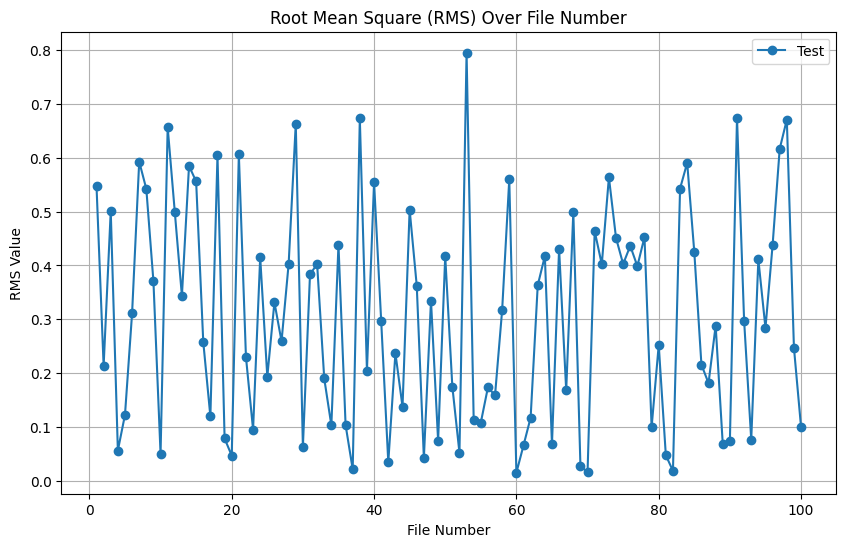

In [15]:
import numpy as np
import matplotlib.pyplot as plt

target_sr=24000
def plot_rms_over_filenumber(audio_tensor, label):
    rms_values = []

    # Calculate RMS for each file
    for i in range(audio_tensor.shape[0]):
        rms_file = np.sqrt(np.mean(audio_tensor[i, 0]**2))  # Consider only the first channel for now
        rms_values.append(rms_file)

    # Plot RMS values
    plt.plot(range(1, len(rms_values) + 1), rms_values, marker='o', label=label)

test_dir = "./datasets/test/clean/"
test_filepaths = helpers.get_file_paths(test_dir)
test_filepaths = test_filepaths[:100]


test_tensor_normal, tensor_srs = helpers.load_and_preprocess(test_filepaths, target_sr)
test_tensor_normal= tf.stack(test_tensor_normal)

# Plot RMS over file number for both test_tensor_normal and train_tensor_normal
plt.figure(figsize=(10, 6))

plot_rms_over_filenumber(test_tensor_normal, label='Test')
#plot_rms_over_filenumber(train_tensor_normal, label='Train')

plt.title('Root Mean Square (RMS) Over File Number')
plt.xlabel('File Number')
plt.ylabel('RMS Value')
plt.legend()
plt.grid(True)
plt.show()


